In [1]:
import torch
import random
import time
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import json
import ast
import copy
import os
import pandas as pd
# from grid6_path_model_utils import * 

### Calculate wcd and belief inference

In [2]:
data = pd.read_csv('formal200-reachgoal.csv')

Actions_wstay = [(1,0), (-1,0), (0,1), (0,-1), (0,0)]
grid_size = 6
human_exp_actions = [(-1, 0), (1,0), (0,-1), (0,1)]
human_action_map = [1,0,3,2]

In [3]:
## belief inference 
%load_ext autoreload
%autoreload 2
from belief_inference_utils import *

In [4]:
human_model = torch.load('model_grid6.pt', map_location=torch.device('cpu'))


layouts = torch.zeros([4,30,4,6,6])

p = '../data/grid6/mturk_validation/'

for i, file in enumerate([
            'original_environments.pt',
            'our_approach_optimal_model.pt',
            'greed_true_data_driven.pt',
            'our_approach_data_driven.pt',
            ]):
    mapdata = torch.load(p + file , map_location=torch.device('cpu'))
    mapdata = torch.max(torch.zeros_like(mapdata), mapdata)
    layouts[i] = mapdata


In [5]:
data_shuffled = data.sample(frac=1, random_state=123)  # Set random_state for reproducibility

# Method 2: Using NumPy's random permutation
data_shuffled = data.reindex(np.random.permutation(data.index)) 

# Example usage with resetting the index 
data_shuffled = data_shuffled.reset_index(drop=True) 

In [6]:
def generate_path(start_pos, actions):
    ## actions = moves, are current action; while path returns the passed positions
    Actions = [(1,0), (-1,0), (0,1), (0,-1)]
    ans = []
    tmp_pos = start_pos
    for a in actions:
        tmp_pos = (tmp_pos[0] + Actions[a][0], tmp_pos[1] + Actions[a][1],)
        ans.append(tmp_pos)
    return ans 

def get_distance_prob_shortest(goals, start_pos, layout, paths):
    ans = []
    for g in goals:
        dis = build_map(layout, start_pos = g)
        ans.append(dis[start_pos[0], start_pos[1]] - dis[paths[-1][0], paths[-1][1]]  ) ## start_point is always 0 
    return softmax(ans)

def build_map(layout, start_pos):
    dis = np.ones((6,6), dtype = int) * 100
    dis[start_pos[0], start_pos[1]] = 0
    blocked = layout[1].numpy().astype(int)
    Actions = [(1,0), (-1,0), (0,1), (0,-1)]
    distance = 0
    candidate_list = [start_pos]
    while len(candidate_list) >= 1 and distance <=20:  ## make sure no dead lock, and ignore rate cases where distance might be > 20
        for i, j in candidate_list:
            ## assign value 
            for a in Actions:
                m, n = i+a[0], j+a[1]
                if m>=0 and m<6 and n>=0 and n<6:
                    if blocked[m,n] == 0:
                        dis[m, n] = min (1+distance ,  dis[m, n])
        distance += 1
        candidate_list = list(np.argwhere(dis == distance))
        # print(len(candidate_list), distance)
    return dis

In [7]:
goal_inference_method = "bayesian" # or "shortest_distance"
rerun_bayesian_inference = False

In [8]:
if rerun_bayesian_inference:
    treatment =[0,]
    percentages = [0.1,0.2, 0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1]
    # percentages = [0.1,0.5,0.8, 1]
    treatment_accuracies = []
    for treatment in range(4):
        accuracies = []
        for i in range(500):
            row = data_shuffled.iloc[i]
            if not row["reach_goal"] or row['treatment'] != treatment: 
                # accuracies.append( [-1]*len(percentages))
                continue
            env_accuracy = []
            for percent in percentages:
                goal_id = row['goal']
                actions = row['actions']
                actions = [human_action_map[int(s)] for s in actions[1:-1].split(',')]
                num_obs_actions = int(np.max([1,np.floor(percent*len(actions))]))
                game = layouts[row['treatment'], row['gameidx2']]
                n, goal_pos, block_pos, start_pos, spaces_pos = decode_grid_design(game, return_map = False)

                if goal_inference_method == "bayesian":
                    goal_prob = get_human_prob(human_model, 6, goal_pos, block_pos, start_pos, actions[:num_obs_actions])
                else:
                    path = generate_path(start_pos, actions[:num_obs_actions])
                    dis_prob = get_distance_prob_shortest(goal_pos, start_pos, game, path)

                # get_distance_prob_shortest

                env_accuracy.append(int(goal_id==np.argmax(goal_prob)))
            accuracies.append(env_accuracy)
        treatment_accuracies.append(accuracies)
        print(treatment,np.mean(accuracies, axis=0))
    means = [np.mean(treatment_accuracies[i], axis=0)*100 for i in range(4)]
    std_errors = [
        (np.std(treatment_accuracies[i], axis=0) / np.sqrt(len(treatment_accuracies[i])))*100
        for i in range(4)
    ]
else:
    data = np.load("bayesian_mean_std6k.npz")
    means, std_errors, percentages = data['means'], data['std'], data['percentages']

In [10]:
# for i in range(4):
#     print(i,np.std(treatment_accuracies[i], axis =0)/np.sqrt(len(treatment_accuracies[i])))

In [11]:
idx = np.sum(np.array([percentages <= 0.9, percentages == 1.0]), axis =0) ==1
percentages = percentages[idx]
means = [means[i][idx] for i in range(4)]
std_errors = [std_errors[i][idx] for i in range(4)]
# np.size(percentages)

In [19]:
means[0].shape

(10,)

In [13]:
means

[array([ 51.96078431,  56.33986928,  53.26797386,  52.2875817 ,
         55.68627451,  60.65359477,  66.66666667,  71.4379085 ,
         77.18954248, 100.        ]),
 array([ 57.94871795,  60.32051282,  57.88461538,  60.51282051,
         65.70512821,  66.79487179,  69.61538462,  73.26923077,
         78.07692308, 100.        ]),
 array([ 53.0924253 ,  55.2466991 ,  60.94510076,  56.01111883,
         59.5552467 ,  62.75191105,  69.00625434,  76.44197359,
         78.6657401 , 100.        ]),
 array([ 60.47619048,  63.06122449,  65.71428571,  65.30612245,
         68.23129252,  72.10884354,  75.17006803,  78.7755102 ,
         83.06122449, 100.        ])]

In [14]:
np.array([percentages <= 0.9, percentages == 0.9, percentages == 1.0])

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
        False],
       [False, False, False, False, False, False, False, False,  True,
        False],
       [False, False, False, False, False, False, False, False, False,
         True]])

# Accuracy of Inference by modification type

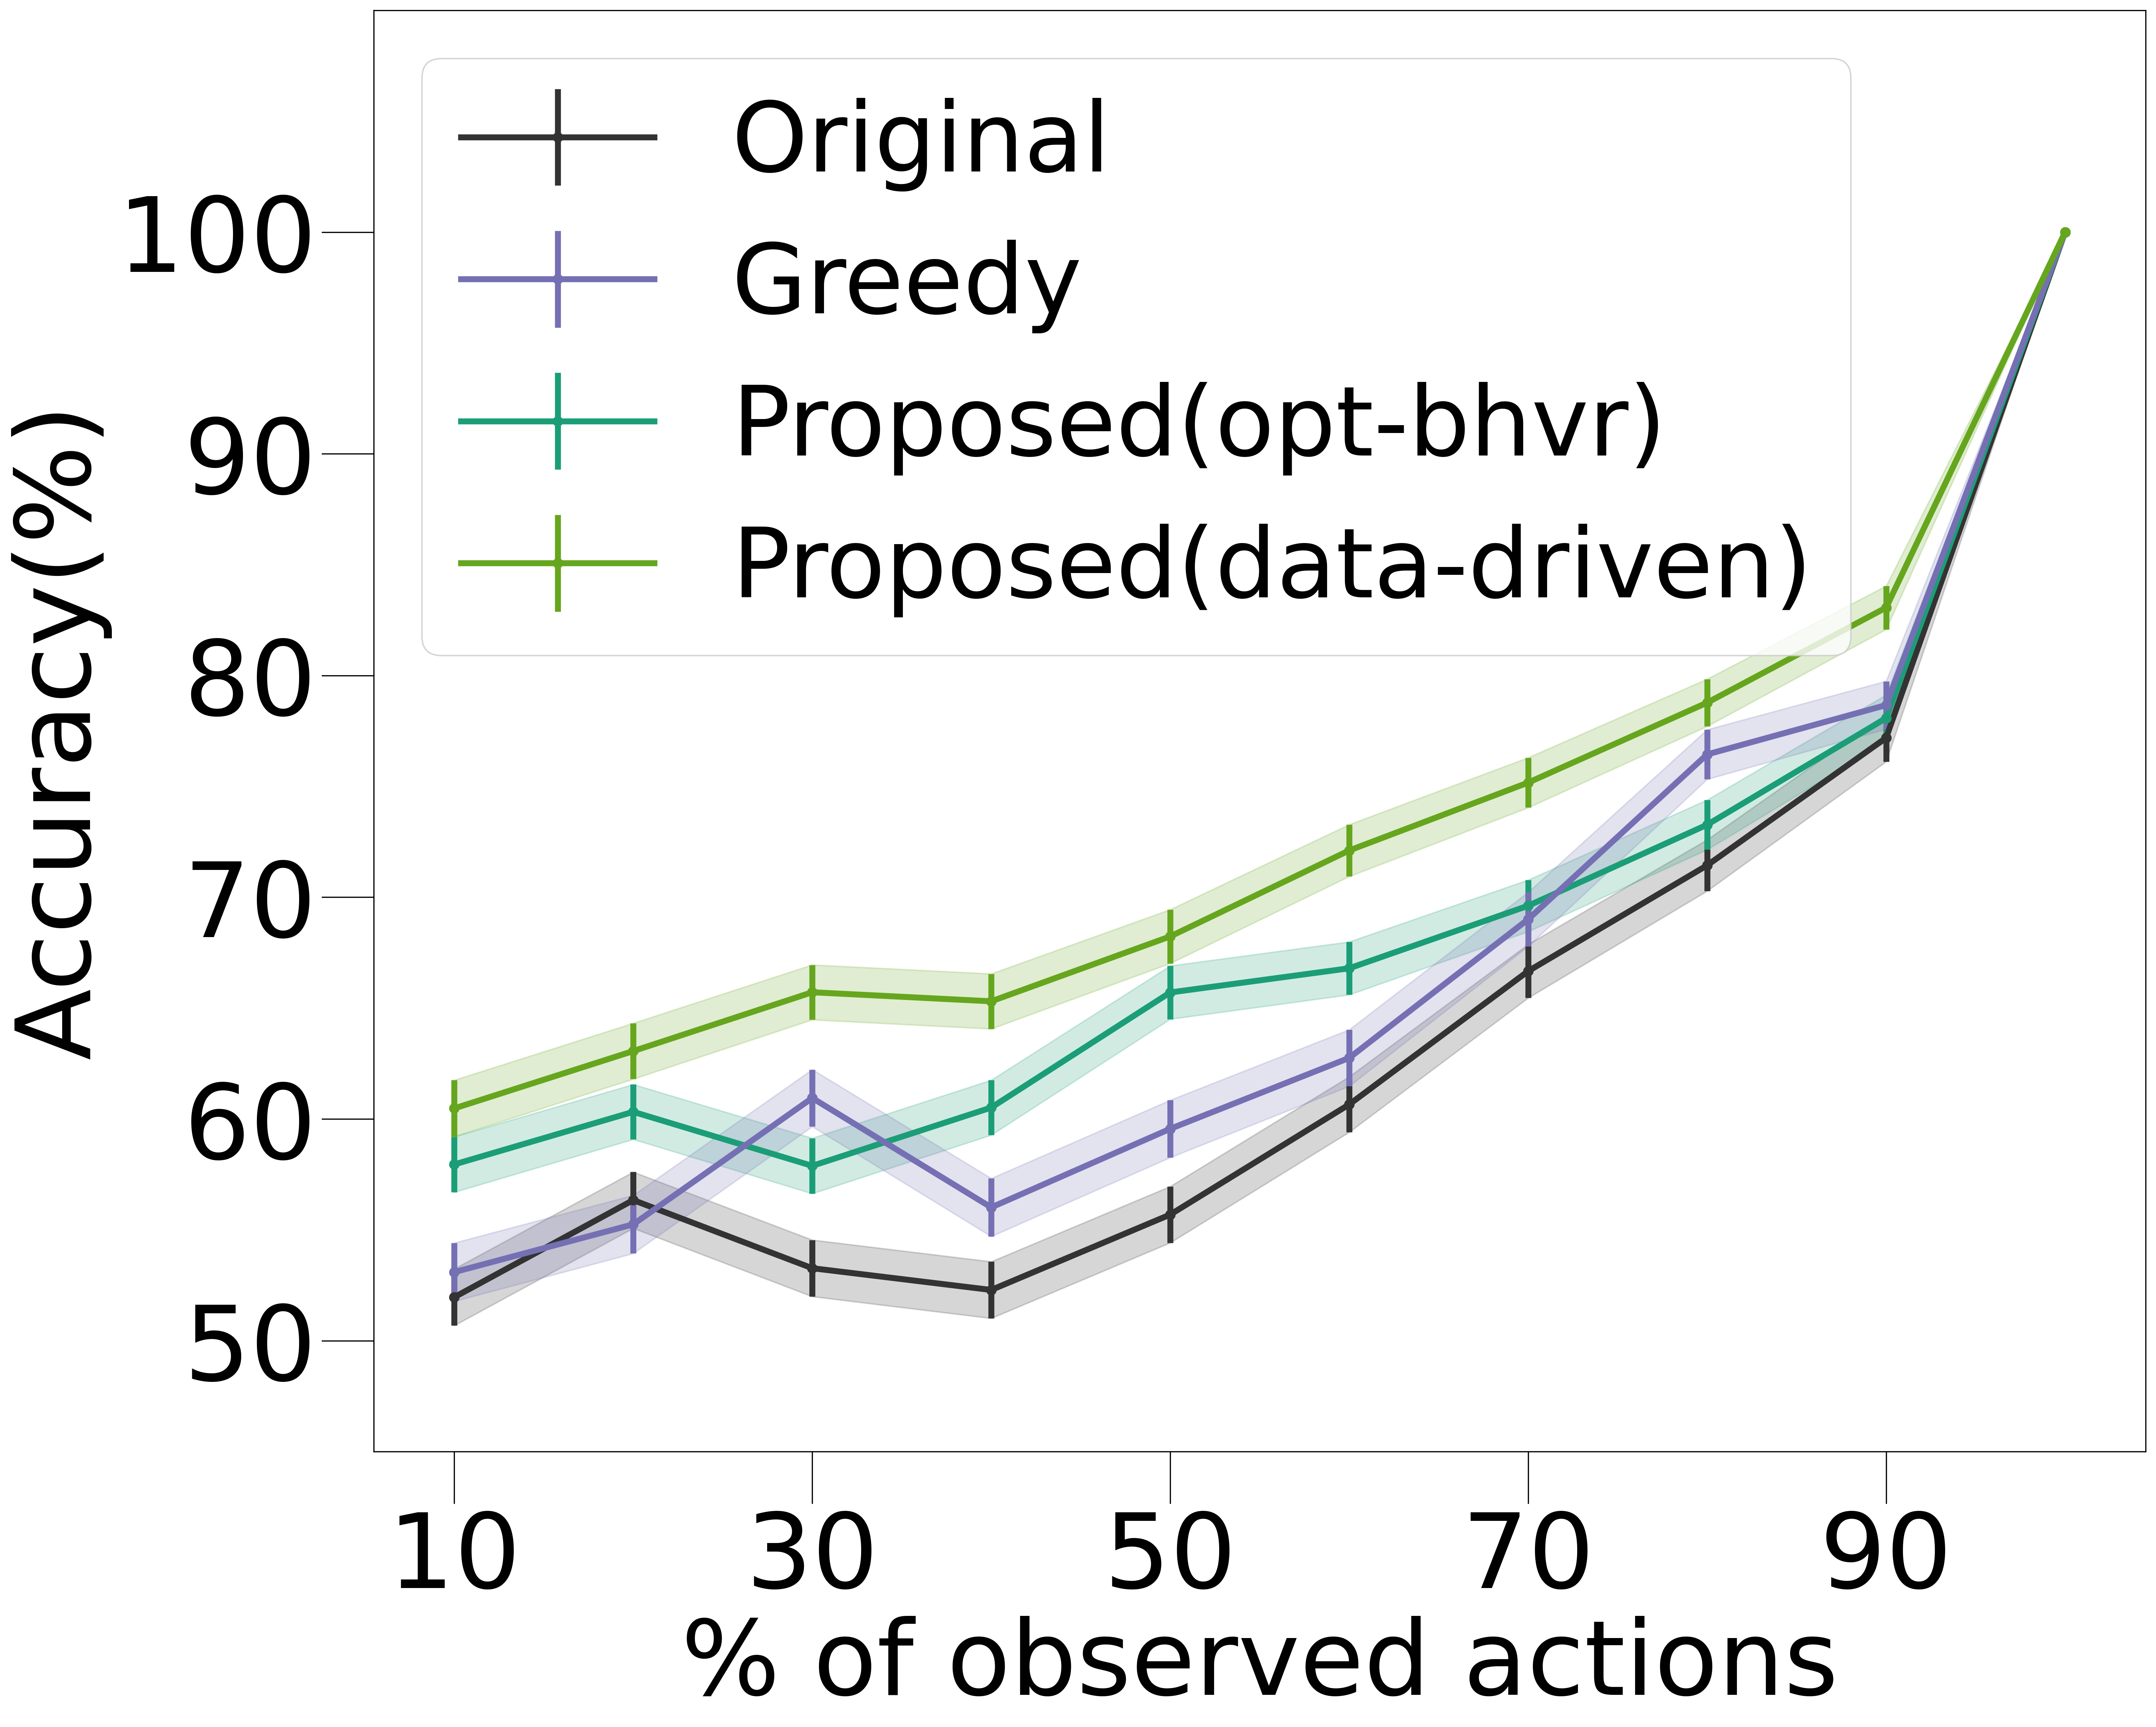

In [15]:
# Calculate means and standard errors
fig, ax = plt.subplots(figsize=(20, 16),dpi=300, constrained_layout=True)
font_size =70


# Create the plot
x_values = np.array(percentages)*100  # or range(1, 5) if you want labels as 1, 2, 3, 4

treatments = ["Original","Proposed(opt-bhvr)","Greedy","Proposed(data-driven)"]
colors = ["#333333","#1b9e77","#7570b3","#66a61e"]
for i in range(4):
    ax.errorbar(x_values, means[i], yerr=std_errors[i], fmt='o-', label =treatments[i], color =colors[i], linewidth = 4 )
    ax.fill_between(x_values, means[i] - std_errors[i],
                                 means[i] + std_errors[i], alpha=0.2,
                                 color=colors[i])

# Customize the plot
ax.set_xlabel('% of observed actions',fontsize=font_size)  # Replace with appropriate label
plt.ylabel('Accuracy(%)',fontsize=font_size)         # Replace with appropriate label
# plt.title('Bayesian Inference Accuracy of Goal')
plt.legend(fontsize=font_size-5)

# Extract handles and labels
handles, labels = ax.get_legend_handles_labels()

# Define the desired order
desired_order = [0,2,1,3]  # New order: Orginal, Greedy, Prop(opt-bhvr) and Prop (data-driven)

# Reorder handles and labels
handles = [handles[i] for i in desired_order]
labels = [labels[i] for i in desired_order]

ax.legend(handles, labels, fontsize=font_size - 5)


plt.xticks(range(10,105,20),fontsize =font_size )  # Adjust if needed
plt.yticks(range(50,105,10),fontsize =font_size )  # Adjust if needed
ax.tick_params(axis='both', which='major', length=font_size/2)

plt.ylim([45,110])
# plt.xlim([7,105])

plt.savefig(f"plots/{goal_inference_method}_inference.pdf", dpi=300)

plt.show()